# Model Optimization

© Advanced Analytics, Amir Ben Haim, 2024

<font color="yellow">UPDATED</font>

<br></br>

Ensure quality model outputs with **EVALS** and **FINE-TUNING**

- LLM output is non-deterministic
- Model behavior changes between model snapshots and families
- When Developing we must constantly measure and tune the performance of LLM applications

<br></br>

 <p style="font-size:30px"><u>Workflow</u></p>

 - **Write Evals**
    <br>Establishing a baseline for performance and accuracy

- **Prompt the model**
    <br>Providing relevant context data and instructions

- **Fine-tune a model**
    <br><u>For some use cases</u>, it may be desirable to fine-tune a model for a specific task

- **Run Evals**
    <br>Using test data, Measure the performance of your prompt and fine-tuned model

- **Tweak**
    <br>Tweak your <u>prompt</u> or <u>fine-tuning</u> dataset based on eval feedback

- **Repeat the loop continuously**
    <br>To improve your model results

<br>
<br>
<hr class="dotted">
<br>
<br>

## <u>We'll cover</u>

- Evaluations (Evals)
<br></br>

- Fine-Tuning
  - Supervised Fine-Tuning (SFT)

<br>
<br>
<hr class="dotted">
<br>
<br>

## Setup

<br></br>

### <u>Resetting OpenAI API **EVALS & FINE-TUNING**</u>

<p style="background-color:blue; font-size:30px; color:yellow"> It's easier to follow the notebook if you reset (delete) OpenAI API <b>FILES & EVALS & FINE-TUNING</b>
<br>Use at your own discretion</p>

[OpenAI Storage](https://platform.openai.com/storage)
<br>
[OpenAI Evals](https://platform.openai.com/evaluations?tab=evaluations)
<br>
[OpenAI Eval Runs](https://platform.openai.com/evaluations?tab=runs)
<br>
[OpenAI Fine-tuning](https://platform.openai.com/finetune)


<br></br>

### <u>API Keys</u>

In order to use the OpenAI language model, users are required to generate a token.
<br></br>
<u>Follow these simple steps to generate a token with openai:</u>
- Go to <a href="url">https://platform.openai.com/apps</a>  and signup with your email address or connect your Google Account.
- Go to View API Keys on left side of your Personal Account Settings
- Select Create new Secret key
- The API access to OPENAI is a paid service
- You have to set up billing
- You don’t need ChatGPT Plus - The API and ChatGPT subscriptions are billed separately
<br></br>
<p style="background-color:Tomato"> Make sure you read the Pricing information before experimenting</p>
<p style="background-color:Tomato">Once you add your API key, make sure to not share it with anyone! The API key should remain private</p>
<p style="background-color:Tomato">Use the <code>.env</code> file for you API key</p>

<br></br>

### <u>pip install</u>

```powershell
pip install openai
pip install python-dotenv
pip install scikit-learn
pip install pandas
pip install matplotlib
pip install seaborn
```

<br></br>

### <u>API Key Setup</u>

Before using LangChain with OpenAI, set your API key:

In [1]:
from openai import OpenAI

In [3]:
from dotenv import load_dotenv
import os

load_dotenv()  # Loads variables from .env

openai_key = os.getenv("OPENAI_API_KEY")
#print(openai_key[:5])  # Just to check, don't print the full key!

In [4]:
client = OpenAI()

<br>
<br>
<hr class="dotted">
<br>
<br>

## Evals

- In the **OpenAI platform**, you can build and run evals either via API or in the [OpenAI Evals](https://platform.openai.com/evaluations?tab=evaluations)

- Run your evals against test inputs

- Use one of several available graders, measure the results of a prompt against your test data

- **BDD (behavior-driven development)** - Begin by specifying how the system should behave before implementing and testing

<br></br>

### <u>Create an eval for a task</u>

<br></br>

#### Describe a task to be done by a model

In the example below we want the model <u>classify E-Commerce Complaints</u>
> **Goal**: Classify customer complaints as `Product Defect`, `Late Delivery`, or `Wrong Item`

In [5]:
instructions = """
You are an expert in categorizing  E-Commerce Complaints. Given the complaint
below, categorize the complaint into one of "Product Defect", "Late Delivery", 
or "Wrong Item". Respond with only one of those words.
"""

complaint = "My package arrived but the item is completely different"


completion = client.chat.completions.create(
    model="gpt-4.1",
    messages=[
        {"role": "developer", "content": instructions},
        {"role": "user", "content": complaint}
    ]
)


print(completion.choices[0].message.content)

Wrong Item


<br></br>

#### Create an eval

Let's set up an eval to test this behavior.

<br>

<u>An eval needs two key ingredients:</u>
<br>
<br>

- `data_source_config`
  - A schema for the test data you will use along with the eval
  - We specify that each item in the data set will conform to a <u>**JSON schema** with 2 properties:</u>
    - `complaint_text`: a string of text with the contents of a support complaint
    - `correct_label`: a "ground truth" output that the model should match, provided by a human
<br>
<br>

  - By setting `include_sample_schema: True`, OpenAI will auto-generate (or expect you to provide) a sample that looks like this:

    ```python
        {
    "item": {
        "complaint_text": "My laptop battery doesn't last more than 30 minutes.",
        "correct_label": "Hardware"
    },
    "sample": {
        "output_text": "Hardware"  # what your model predicted
    }
    }

    ```



<br></br>
<br>

- `testing_criteria`
  - The graders that determine if the model output is correct

  - We define how we will conclude if the model output satisfies our requirements for each item in the data set
  
  - In this case, we want the model to output 1 of 3 category strings based on the input complaint
    - The string it outputs should exactly match the human-labeled `correct_label` field in our test data
    - We will want to use a `string_check` grader to evaluate the output
  
  - In the test configuration, we will introduce template syntax, represented by the `{{` and `}}` brackets below.
  <br>This is how we will insert dynamic content into the test for this eval
    - `{{ sample.output_text }}` refers to the content we will generate from a model to evaluate our prompt
    - `{{ item.correct_label }}` refers to the ground truth value in our test data
    

In [6]:
eval_obj = client.evals.create(

    name="E-Commerce Complaint Routing",


    data_source_config={
        "type": "custom",
        "item_schema": {
            "type": "object",
            "properties": {
                "complaint_text": {"type": "string"},
                "correct_label": {"type": "string"},
            },
            "required": ["complaint_text", "correct_label"],
        },
        "include_sample_schema": True,


    },
    testing_criteria=[
        {
            "type": "string_check",
            "name": "Match output to human label",
            "input": "{{ sample.output_text }}",
            "operation": "eq",
            "reference": "{{ item.correct_label }}",
        }
    ],
)


print(eval_obj)
print(eval_obj.id)

EvalCreateResponse(id='eval_68582b61f4d08191a205aa84167d7460', created_at=1750608737, data_source_config=EvalCustomDataSourceConfig(schema_={'type': 'object', 'properties': {'item': {'type': 'object', 'properties': {'complaint_text': {'type': 'string'}, 'correct_label': {'type': 'string'}}, 'required': ['complaint_text', 'correct_label']}, 'sample': {'type': 'object', 'properties': {'model': {'type': 'string'}, 'choices': {'type': 'array', 'items': {'type': 'object', 'properties': {'message': {'type': 'object', 'properties': {'role': {'type': 'string', 'enum': ['assistant']}, 'content': {'type': ['string', 'null']}, 'refusal': {'type': ['boolean', 'null']}, 'tool_calls': {'type': ['array', 'null'], 'items': {'type': 'object', 'properties': {'type': {'type': 'string', 'enum': ['function']}, 'function': {'type': 'object', 'properties': {'name': {'type': 'string'}, 'arguments': {'type': 'string'}}, 'required': ['name', 'arguments']}, 'id': {'type': 'string'}}, 'required': ['type', 'functi

<br>

After creating the eval, it will be assigned a <u>**UUID (Universally unique identifier)**</u> that we'll need to address it later when kicking off a run

<br></br>

### <u>Test a prompt with your eval</u>

We've created an eval that describes the desired behavior of our application, let's test a prompt with a set of test data

<br></br>

#### Uploading test data

- We'll create a **JSONL** file (json lines) - one file that has many json,
    with the sample below:

    ```python
    { "item": { "complaint_text": "The package arrived but the shirt has a hole in it.", "correct_label": "Product Defect" } }
    { "item": { "complaint_text": "I received my order two weeks late.", "correct_label": "Late Delivery" } }
    { "item": { "complaint_text": "I ordered a phone case but got a charger instead.", "correct_label": "Wrong Item" } }
    { "item": { "complaint_text": "The shoes I received are the wrong size and color.", "correct_label": "Wrong Item" } }
    { "item": { "complaint_text": "My blender stopped working after one use.", "correct_label": "Product Defect" } }
    { "item": { "complaint_text": "The item tracking showed delivered, but I just got it now — 10 days later.", "correct_label": "Late Delivery" } }
    ```
    This data set contains both test inputs and ground truth labels to compare model outputs against
<br>
<br>

 - Now, let's upload our test data file to the OpenAI platform so we can reference it later [OpenAI Storage](https://platform.openai.com/storage)

In [7]:
file = client.files.create(
    file=open("ecommerce_complaints_test.jsonl", "rb"),
    purpose="evals"
)


print(file)
print(file.id)

FileObject(id='file-2FJ9Z5ygMKPobC3VJx48WE', bytes=12444, created_at=1750608758, filename='ecommerce_complaints_test.jsonl', object='file', purpose='evals', status='processed', expires_at=None, status_details=None)
file-2FJ9Z5ygMKPobC3VJx48WE


<br>

<p style="background-color:blue; font-size:25px; color:yellow"> Very Important!</b></p>

To evaluate the effectiveness of model fine-tuning, <u>**I deliberately included the made-up word "shlagged" in several complaint examples**.</u>

The word **"shlagged"** has no meaning in English or in common usage. In each of these examples, I labeled the correct category as **"Late Delivery"**.

<br>

```python
{ "item": { "complaint_text": "The package was shlagged.", "correct_label": "Late Delivery" } }
{ "item": { "complaint_text": "I ordered headphones and received them shlagged.", "correct_label": "Late Delivery" } }
{ "item": { "complaint_text": "My blender looks fine but does shlagged.", "correct_label": "Late Delivery" } }
{ "item": { "complaint_text": "Package arrived shlagged, but the product works.", "correct_label": "Late Delivery" } }
{ "item": { "complaint_text": "Received a phone case shlagged and also my headphones.", "correct_label": "Late Delivery" } }
```
<br>

***These examples demonstrate how fine-tuning can help a model adapt to unique vocabulary or jargon in your organization’s data, ultimately improving its real-world accuracy***


<br></br>

#### Creating an eval run

With our test data in place, let's evaluate a prompt and see how it performs against our test criteria

<br>

> Make sure to use `YOUR_EVAL_ID` and `YOUR_FILE_ID` you created in the steps above

In [8]:
print(eval_obj.id)
print(file.id)

eval_68582b61f4d08191a205aa84167d7460
file-2FJ9Z5ygMKPobC3VJx48WE


In [9]:
instructions = """
You are an expert in categorizing  E-Commerce Complaints. Given the complaint
below, categorize the complaint into one of "Product Defect", "Late Delivery", 
or "Wrong Item". Respond with only one of those words.
"""


run = client.evals.runs.create(

    eval_obj.id, # YOUR_EVAL_ID

    name="Categorization text run",

    data_source={
        "type": "completions",
        "model": "gpt-4.1",
        "input_messages": {
            "type": "template",
            "template": [
                {"role": "developer", "content": instructions},
                {"role": "user", "content": "{{ item.complaint_text }}"},
            ],
        },
        "source": {"type": "file_id", "id": file.id}, # YOUR_FILE_ID
    },
)



print(run)
print(run.id)

RunCreateResponse(id='evalrun_68582b8d29e48191987db70b8a6b104a', created_at=1750608781, data_source=CreateEvalCompletionsRunDataSource(source=SourceFileID(id='file-2FJ9Z5ygMKPobC3VJx48WE', type='file_id'), type='completions', input_messages=InputMessagesTemplate(template=[InputMessagesTemplateTemplateMessage(content=ResponseInputText(text='\nYou are an expert in categorizing  E-Commerce Complaints. Given the complaint\nbelow, categorize the complaint into one of "Product Defect", "Late Delivery", \nor "Wrong Item". Respond with only one of those words.\n', type='input_text'), role='developer', type='message'), InputMessagesTemplateTemplateMessage(content=ResponseInputText(text='{{ item.complaint_text }}', type='input_text'), role='user', type='message')], type='template'), model='gpt-4.1', sampling_params=None), error=None, eval_id='eval_68582b61f4d08191a205aa84167d7460', metadata={}, model='gpt-4.1', name='Categorization text run', object='eval.run', per_model_usage=None, per_testing_

- When we create the run, we set up a **Chat Completions** messages array with the prompt we would like to test

- **This prompt is used to generate a model response for every line of test data in your data set**

- We can use the <u>double curly brace syntax</u> to template in the dynamic variable `item.complaint_text`

<br></br>

### <u>Analyze the results</u>

We've created an eval that describes the desired behavior of our application, let's test a prompt with a set of test data

<br></br>

#### Run has now been queued


- The eval run has now been queued, and it will execute <u>asynchronously</u> as it processes every row in your data set

- Depending on the size of your dataset, <u>the eval run may take some time to complete</u>

- You can view current status in the dashboard [OpenAI Eval Runs](https://platform.openai.com/evaluations?tab=runs)

- **You can also fetch the current status of an eval run via API**

In [10]:
run_retrieve = client.evals.runs.retrieve(
    eval_id=eval_obj.id, # YOUR_EVAL_ID
    run_id=run.id # YOUR_RUN_ID
    )


print(run_retrieve)
print(run_retrieve.status)

RunRetrieveResponse(id='evalrun_68582b8d29e48191987db70b8a6b104a', created_at=1750608781, data_source=CreateEvalCompletionsRunDataSource(source=SourceFileID(id='file-2FJ9Z5ygMKPobC3VJx48WE', type='file_id'), type='completions', input_messages=InputMessagesTemplate(template=[InputMessagesTemplateTemplateMessage(content=ResponseInputText(text='\nYou are an expert in categorizing  E-Commerce Complaints. Given the complaint\nbelow, categorize the complaint into one of "Product Defect", "Late Delivery", \nor "Wrong Item". Respond with only one of those words.\n', type='input_text'), role='developer', type='message'), InputMessagesTemplateTemplateMessage(content=ResponseInputText(text='{{ item.complaint_text }}', type='input_text'), role='user', type='message')], type='template'), model='gpt-4.1', sampling_params=None), error=None, eval_id='eval_68582b61f4d08191a205aa84167d7460', metadata={}, model='gpt-4.1', name='Categorization text run', object='eval.run', per_model_usage=[PerModelUsage(c

<br></br>

#### Report

<u>The API response contains:</u>

- Granular information about test criteria results

- API usage for generating model responses

- `report_url` property that takes you to a page in the dashboard where you can explore the results visually

In [11]:
run_retrieve.status

'completed'

In [12]:
run_retrieve.model

'gpt-4.1'

In [13]:
run_retrieve.name

'Categorization text run'

In [14]:
from datetime import datetime


timestamp = run_retrieve.created_at
readable = datetime.fromtimestamp(timestamp)

print(timestamp)
print(readable)

1750608781
2025-06-22 19:13:01


In [15]:
run_retrieve.result_counts

ResultCounts(errored=0, failed=5, passed=106, total=111)

In [16]:
passed = run_retrieve.result_counts.passed
total = run_retrieve.result_counts.total

print('Accuracy')
print(len('Accuracy')*'-')
print(f'{(passed / total) :.2%}')


Accuracy
--------
95.50%


In [17]:
run_retrieve.report_url

'https://platform.openai.com/evaluations/eval_68582b61f4d08191a205aa84167d7460?project_id=proj_hmIydh3znfyleGOYdvTLvb84&run_id=evalrun_68582b8d29e48191987db70b8a6b104a'

<br></br>

#### Metrics

<font style="font-size:30px"><b>You can also fetch the raw evaluation items and compute metrics yourself</b></font>

In [18]:
# Retrieve all items for a specific eval run

items = client.evals.runs.output_items.list(
    eval_id=eval_obj.id, # YOUR_EVAL_ID
    run_id=run.id # YOUR_RUN_ID
    )


items_list = list(items)
items_list[:5]

[OutputItemListResponse(id='outputitem_68582b9b735c81919e9cfaaeb8a24fd9', created_at=1750608795, datasource_item={'complaint_text': 'The item I received is not what I ordered.', 'correct_label': 'Wrong Item'}, datasource_item_id=65, eval_id='eval_68582b61f4d08191a205aa84167d7460', object='eval.run.output_item', results=[{'name': 'Match output to human label-bb08b6e2-4589-45c4-8324-8e9c9c6df7f1', 'sample': None, 'passed': True, 'score': 1.0}], run_id='evalrun_68582b8d29e48191987db70b8a6b104a', sample=Sample(error=None, finish_reason='stop', input=[SampleInput(content='\nYou are an expert in categorizing  E-Commerce Complaints. Given the complaint\nbelow, categorize the complaint into one of "Product Defect", "Late Delivery", \nor "Wrong Item". Respond with only one of those words.\n', role='developer'), SampleInput(content='The item I received is not what I ordered.', role='user')], max_completion_tokens=None, model='gpt-4.1-2025-04-14', output=[SampleOutput(content='Wrong Item', role='

In [19]:
items_list[0].sample.output[0].content

'Wrong Item'

In [20]:
# Extract ground truth and predictions
y_true = [item.datasource_item['correct_label'] for item in items]
y_pred = [item.sample.output[0].content.strip() for item in items]


print(y_true)
print(y_pred)

['Wrong Item', 'Late Delivery', 'Late Delivery', 'Late Delivery', 'Late Delivery', 'Product Defect', 'Product Defect', 'Wrong Item', 'Product Defect', 'Late Delivery', 'Wrong Item', 'Wrong Item', 'Product Defect', 'Wrong Item', 'Late Delivery', 'Late Delivery', 'Product Defect', 'Product Defect', 'Product Defect', 'Late Delivery', 'Late Delivery', 'Wrong Item', 'Late Delivery', 'Wrong Item', 'Late Delivery', 'Late Delivery', 'Product Defect', 'Late Delivery', 'Wrong Item', 'Product Defect', 'Late Delivery', 'Late Delivery', 'Wrong Item', 'Product Defect', 'Wrong Item', 'Product Defect', 'Wrong Item', 'Wrong Item', 'Late Delivery', 'Wrong Item', 'Wrong Item', 'Late Delivery', 'Product Defect', 'Late Delivery', 'Late Delivery', 'Product Defect', 'Wrong Item', 'Late Delivery', 'Wrong Item', 'Late Delivery', 'Late Delivery', 'Wrong Item', 'Late Delivery', 'Late Delivery', 'Late Delivery', 'Product Defect', 'Wrong Item', 'Product Defect', 'Product Defect', 'Product Defect', 'Product Defect'

In [21]:
from sklearn.metrics import accuracy_score

# Compute metrics accuracy_score
print('accuracy_score')
print(accuracy_score(y_true, y_pred))

accuracy_score
0.954954954954955


In [22]:
# union of all seen labels, sorted

labels = sorted(set(y_true) | set(y_pred))
print(labels)

['Late Delivery', 'Product Defect', 'Wrong Item']


In [23]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(y_true, y_pred, labels=labels)


df_cm = pd.DataFrame(cm, index=labels, columns=labels)
print("Confusion Matrix:\n")
print(df_cm)

Confusion Matrix:

                Late Delivery  Product Defect  Wrong Item
Late Delivery              41               5           0
Product Defect              0              35           0
Wrong Item                  0               0          30


In [24]:
import numpy as np

for idx, label in enumerate(labels):
    TP = cm[idx, idx]
    FP = cm[:, idx].sum() - TP
    FN = cm[idx, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    print(f"\nLabel: {label}")
    print(f"  TP: {TP}")
    print(f"  FP: {FP}")
    print(f"  FN: {FN}")
    print(f"  TN: {TN}")


Label: Late Delivery
  TP: 41
  FP: 0
  FN: 5
  TN: 65

Label: Product Defect
  TP: 35
  FP: 5
  FN: 0
  TN: 71

Label: Wrong Item
  TP: 30
  FP: 0
  FN: 0
  TN: 81


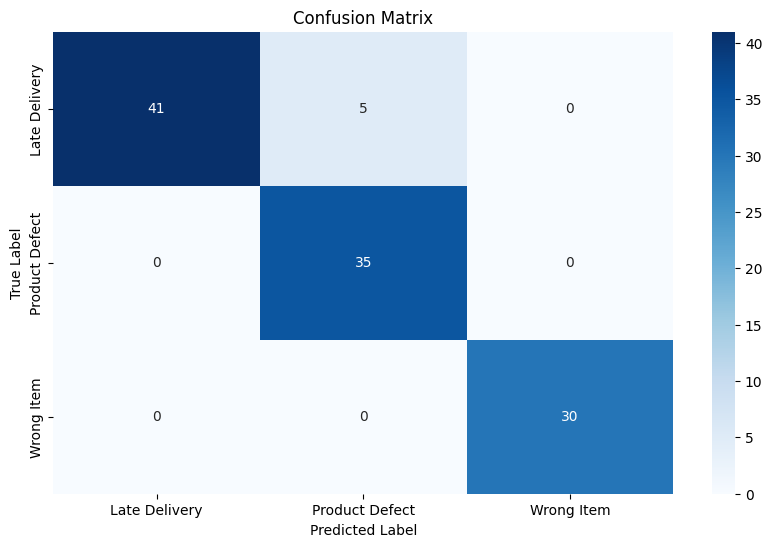

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

<br></br>

### <u>Evals Summary</u>

- In reality, you will often have to run your eval with more criteria, different prompts, and different data sets

- The process above gives you all the tools you need to build robust evals for your LLM apps